In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, accuracy_score

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/Raw/metacritic_games.csv")
test = df.copy()

In [3]:
df["number_players"] = df["number_players"].fillna("no se sabe")
df["rating"] = df["rating"].fillna("nada")
df["genre"] = df["genre"].fillna("otro")
df["developer"] = df["developer"].fillna("Desconocido")

In [4]:
test = df.groupby("genre")["user_score"].mean().reset_index()
test.columns = ["genre","media"]
test2 = df.groupby("genre")["metascore"].mean().reset_index()
test2.columns = ["genre","media"]

In [5]:
df['Media_usuario'] = np.nan
df['Media_meta'] = np.nan

for _, row in test.iterrows():
    categoria = row['genre']
    media_correspondiente = row['media']
    df.loc[df['genre'] == categoria, 'Media_usuario'] = media_correspondiente

for _, row in test2.iterrows():
    categoria = row['genre']
    media_correspondiente = row['media']
    df.loc[df['genre'] == categoria, 'Media_meta'] = media_correspondiente

In [6]:
label_encoder = LabelEncoder()
df["platform"] = label_encoder.fit_transform(df["platform"])
df["genre"] = label_encoder.fit_transform(df["genre"])
df["number_players"] = label_encoder.fit_transform(df["number_players"])
df["rating"] = label_encoder.fit_transform(df["rating"])

filas_con_nan = df[df.isna().any(axis=1)]
filas_con_nan

,game,platform,developer,genre,number_players,rating,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score,Media_usuario,Media_meta


In [7]:
df = df.drop(["developer","release_date","game"], axis=1)

In [8]:
filas_con_nan = df[df.isna().any(axis=1)]
filas_con_nan

,platform,genre,number_players,rating,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score,Media_usuario,Media_meta


In [9]:
#sacar la media de reviews por genero

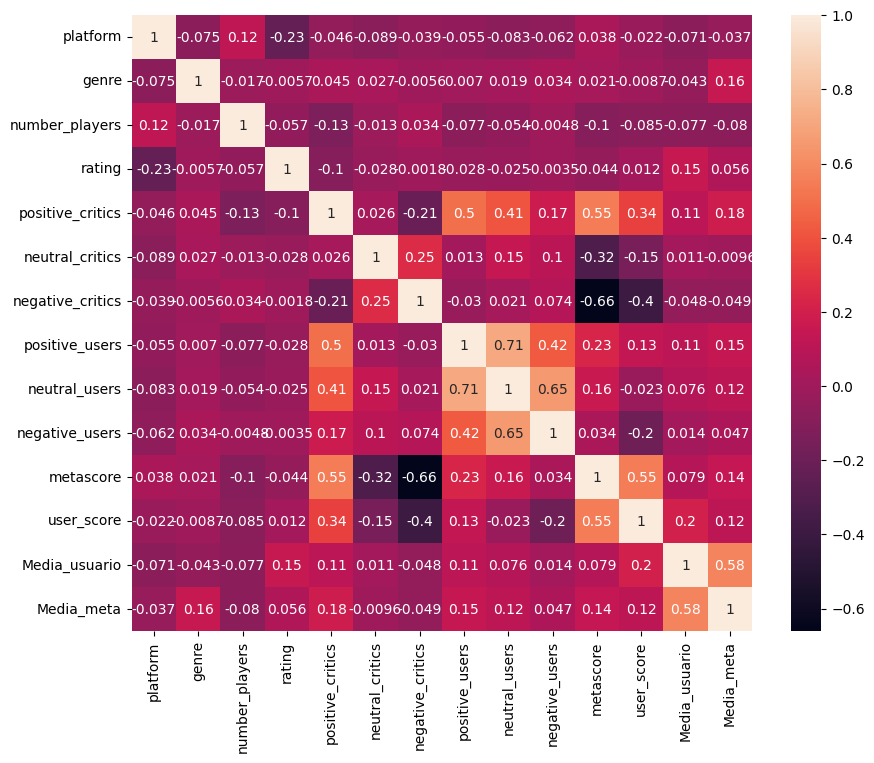

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True);

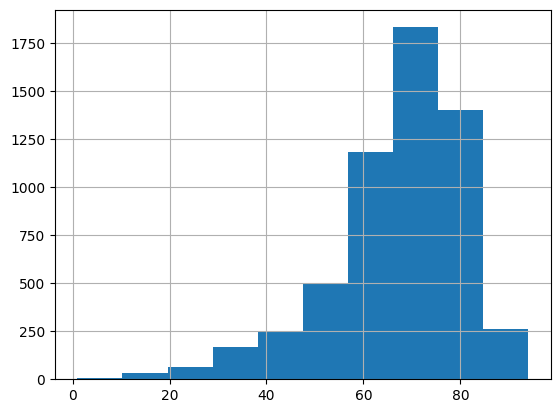

In [11]:
df["user_score"].hist();

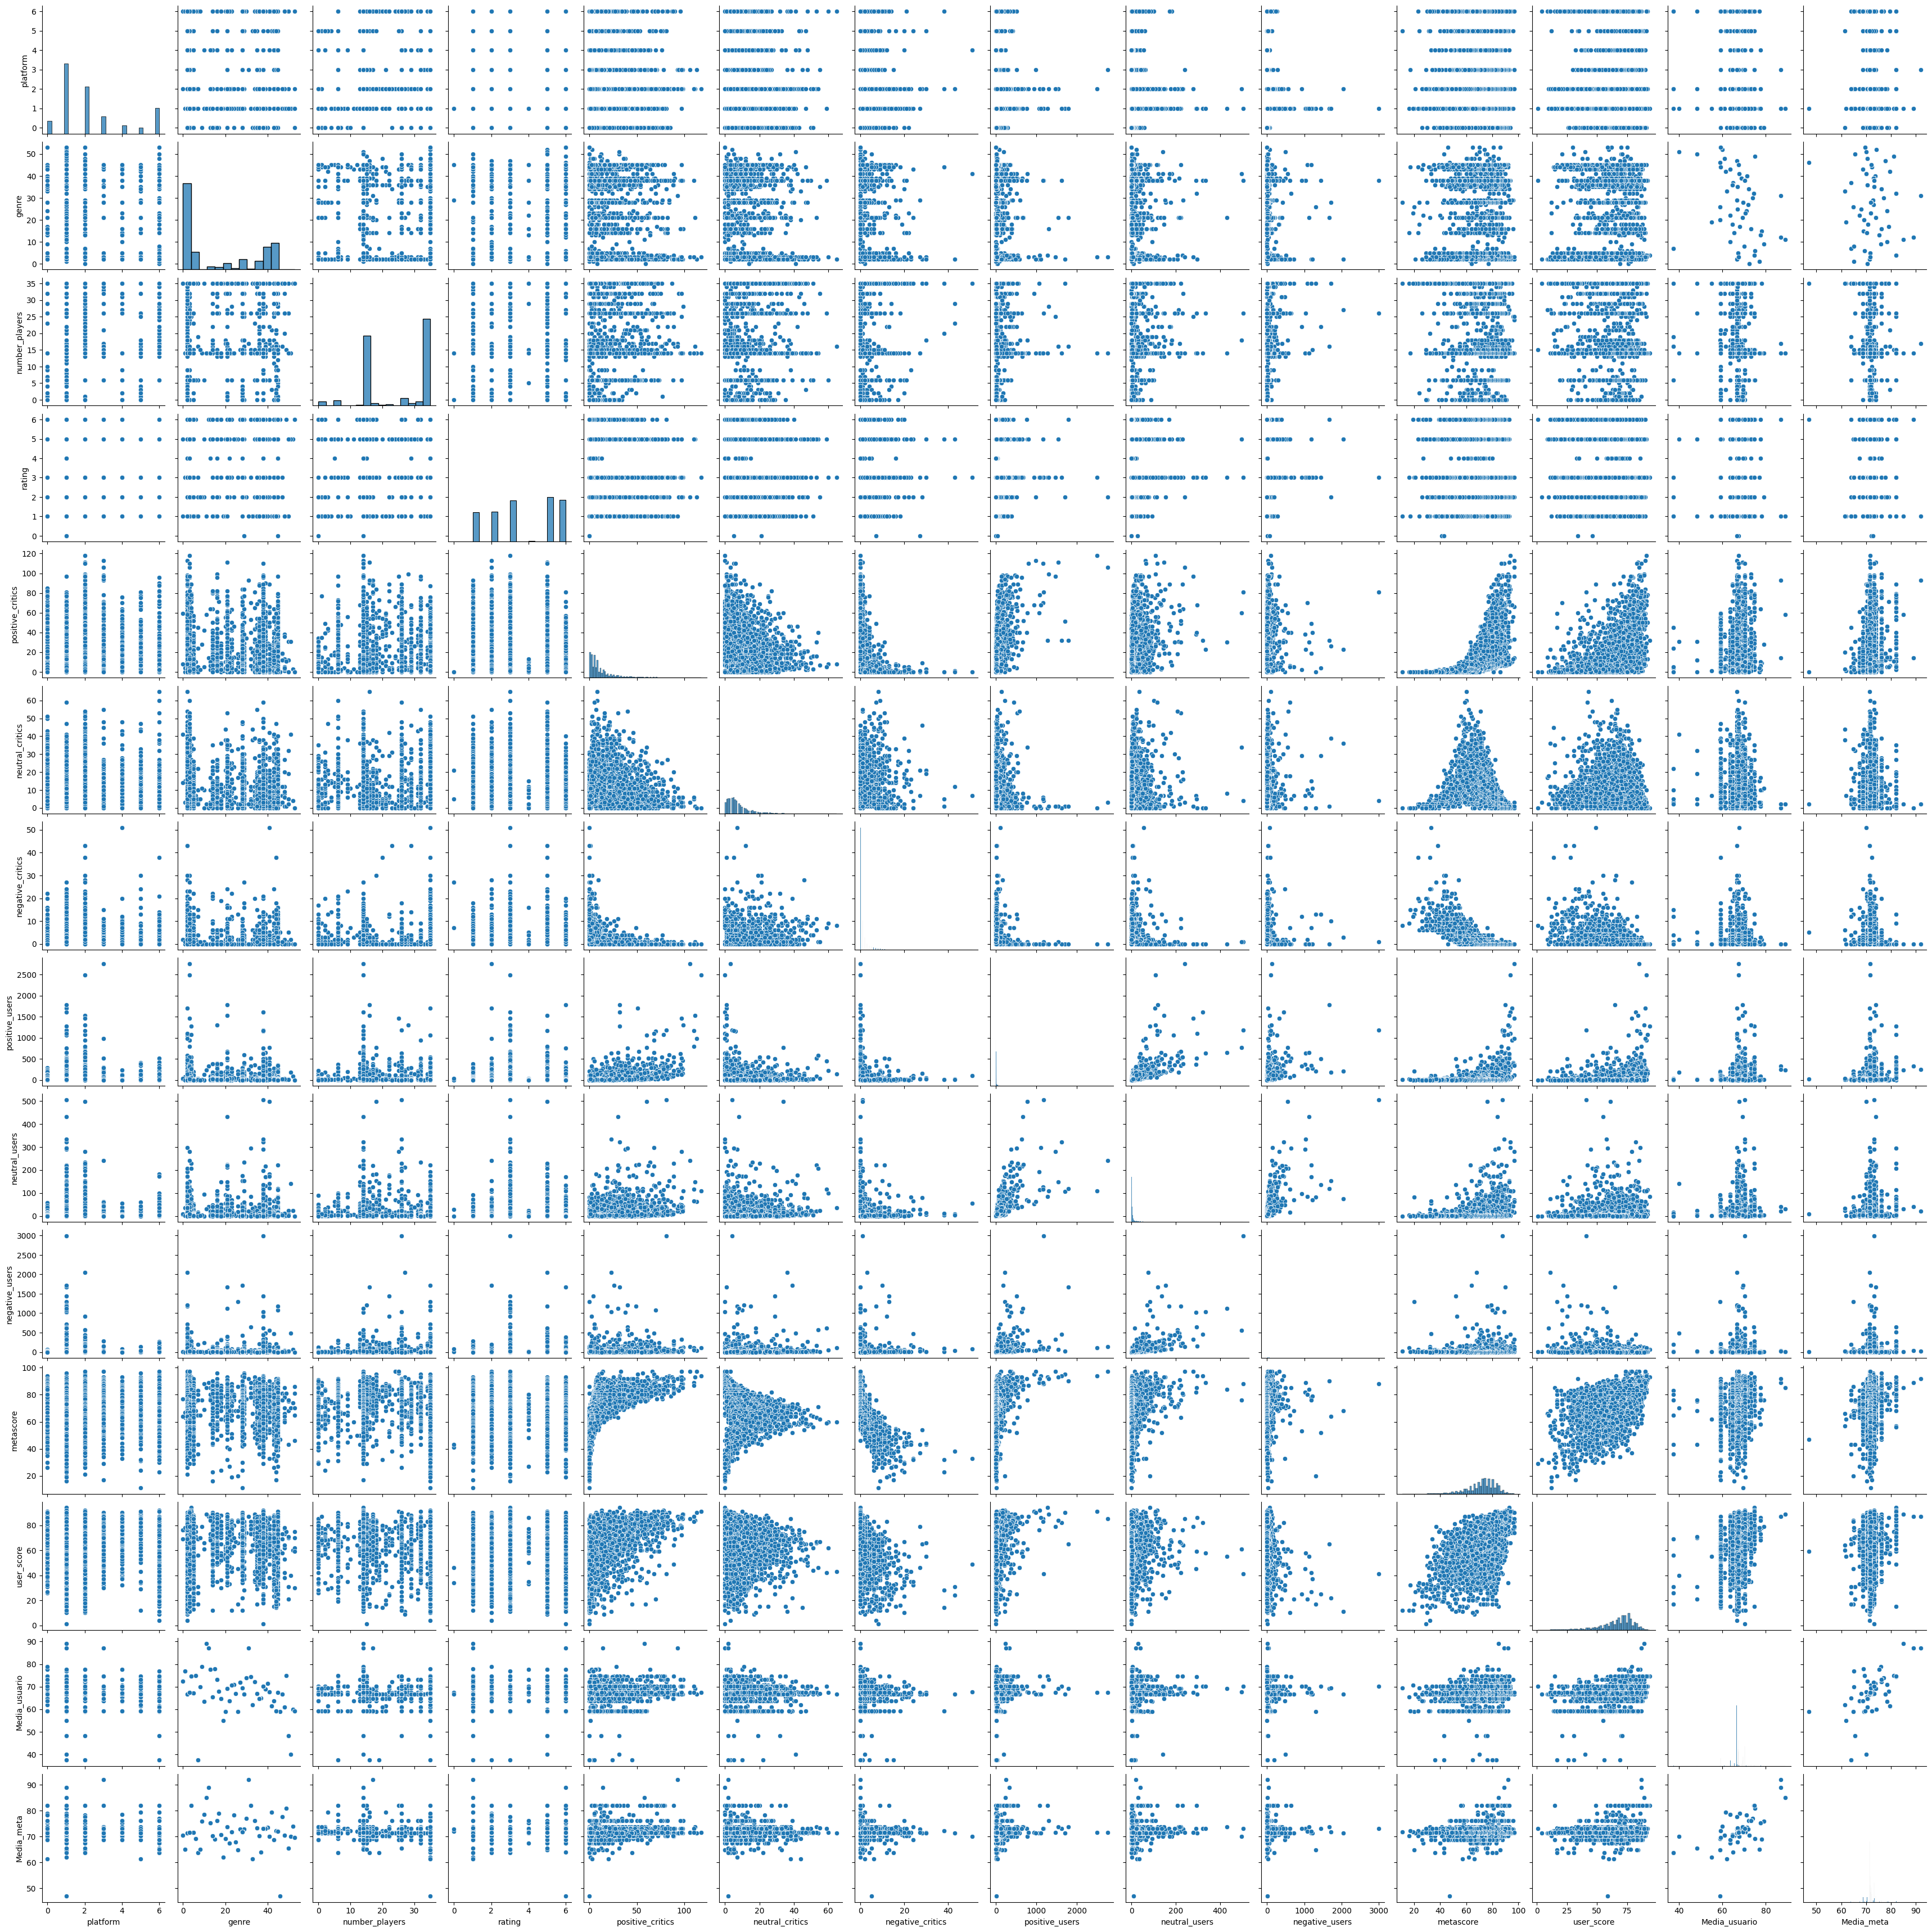

In [12]:
sns.pairplot(df);

In [51]:
def guardar_datos(data,nombre, direccion):
    nombre = nombre +".csv"
    data.to_csv(f"../data/{direccion}/{nombre}",index=False)

guardar_datos(df,"reviews", "procesed")

In [49]:
test = df.tail(1000)
df = df.drop(df.tail(1000).index)
train = df.copy()

In [50]:
guardar_datos(train, "train","train")
guardar_datos(test, "test","test")

In [54]:
#vamos a probar una regresion lineal, ya tenemos nuestra X e y
def regression(train,test, target):
    train = train.select_dtypes(exclude=['object'])
    test = test.select_dtypes(exclude=['object'])
    obj = train[target]
    obj_test = test[target]
    test = test.drop([target],axis=1)
    train = train.drop([target],axis=1)
    model = LinearRegression()

    X = train
    y = obj

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1)
    
    model.fit(X_train,y_train)

    pred = model.predict(test)

    print(X_train.shape)
    print(y_train.shape)
    print(pred.shape)
    print(test.shape)

    print("Media Target: ", y.mean())
    print("Intercept: ",model.intercept_)
    print("Model: ", model.coef_)
    print("R2", round(r2_score(obj_test, pred),3))
    print("MAE", round(mean_absolute_error(obj_test, pred),3))
    print("MAPE", round(mean_absolute_percentage_error(obj_test, pred),3))
    print("MSE", round(mean_squared_error(obj_test, pred),3))
    print("RMSE", round(np.sqrt(mean_squared_error(obj_test, pred)),3))
    filename = 'modelo_regression_lineal.pkl'



    fig, ax = plt.subplots()
    sns.scatterplot(pred, label = "predicciones.")
    sns.scatterplot(obj_test.reset_index(drop=True), label= "Objetivo")
    ax.legend(title="variable", bbox_to_anchor=(1, 1), loc='upper left')
    ax.set_title('Scatter pred VS obj')
    plt.show()

    with open(filename, 'wb') as archivo_salida:
        pickle.dump(model, archivo_salida)

In [17]:
#vamos a probar una regresion lineal, ya tenemos nuestra X e y
def polynominal(train,test, target):
    train = train.select_dtypes(exclude=['object'])
    test = test.select_dtypes(exclude=['object'])
    obj = train[target]
    obj_test = test[target]
    test = test.drop([target],axis=1)
    train = train.drop([target],axis=1)
    model = LinearRegression()

    X = train
    y = obj

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1)
    
    poly = PolynomialFeatures(degree=2)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scal = scaler.transform(X_train)
    X_test_scal = scaler.transform(test)
    poly.fit(X_train_scal)
    X_poly_train = poly.transform(X_train_scal)
    X_poly_test = poly.transform(X_test_scal)

    pol_reg4_reg = Ridge(alpha=0.1)
    pol_reg4_reg.fit(X_poly_train, y_train)

    pred = pol_reg4_reg.predict(X_poly_test)



    print(X_train.shape)
    print(y_train.shape)
    print(pred.shape)
    print(test.shape)

    print("Media Target: ", y.mean())
    print("R2", round(r2_score(obj_test, pred),3))
    print("MAE", round(mean_absolute_error(obj_test, pred),3))
    print("MAPE", round(mean_absolute_percentage_error(obj_test, pred),3))
    print("MSE", round(mean_squared_error(obj_test, pred),3))
    print("RMSE", round(np.sqrt(mean_squared_error(obj_test, pred)),3))
    filename = 'modelo_regression_polynominal.pkl'

    with open(filename, 'wb') as archivo_salida:
        pickle.dump(model, archivo_salida)

,platform,genre,number_players,rating,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score,Media_usuario,Media_meta


(2698, 13)
(2698,)
(1000,)
(1000, 13)
Media Target:  68.25750277880697
Intercept:  14.998379187090855
Model:  [-0.10502099 -0.01963906 -0.03284508  0.2447347   0.04089765  0.13615052
 -0.29820507  0.02361366 -0.0772402  -0.02682267  0.59110483  0.77130162
 -0.57213831]
R2 0.346
MAE 7.476
MAPE 0.149
MSE 109.506
RMSE 10.464


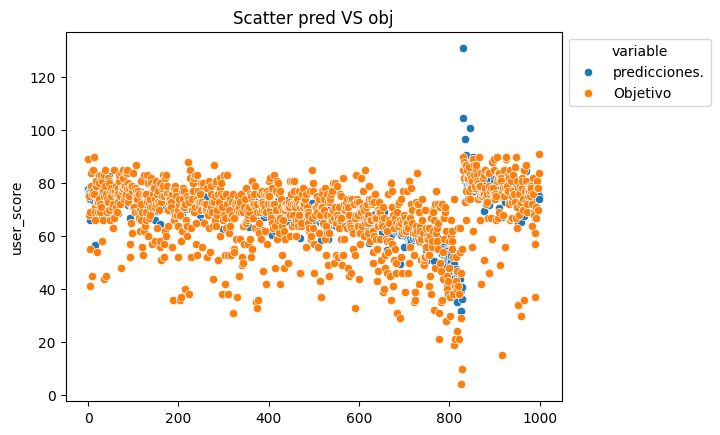

In [55]:
regression(train, test, "user_score")

In [19]:
polynominal(train, test, "user_score")

(4698, 13)
(4698,)
(1000,)
(1000, 13)
Media Target:  67.79208342200468
R2 0.298
MAE 8.865
MAPE 0.228
MSE 154.702
RMSE 12.438


In [20]:
def grid_rfr(train,test, target):
    train = train.select_dtypes(exclude=['object'])
    test = test.select_dtypes(exclude=['object'])
    obj = train[target]
    obj_test = test[target]
    test = test.drop([target],axis=1)
    train = train.drop([target],axis=1)


    X = train
    y = obj

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1)
    
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
    ])

    parameters = {
        'scaler__with_mean': [True, False],
        'scaler__with_std': [True, False],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 5, 10],
        'regressor__min_samples_split': [2, 5, 10]
    }

    rfr_gs = GridSearchCV(estimator=pipe, param_grid=parameters, cv=3, scoring="accuracy", verbose=3, n_jobs=-1)
    rfr_gs.fit(X_train, y_train)
    final_rfr = rfr_gs.best_estimator_
    final_rfr.fit(X_train, y_train)
    pred = final_rfr.predict(test)


    print("Media Target: ", y.mean())
    print("R2", round(r2_score(obj_test, pred),3))
    print("MAE", round(mean_absolute_error(obj_test, pred),3))
    print("MAPE", round(mean_absolute_percentage_error(obj_test, pred),3))
    print("MSE", round(mean_squared_error(obj_test, pred),3))
    print("RMSE", round(np.sqrt(mean_squared_error(obj_test, pred)),3))
    sns.scatterplot(pred)
    sns.scatterplot(obj_test.reset_index(drop=True))
    filename = 'modelo_regression_RFR.pkl'

    with open(filename, 'wb') as archivo_salida:
        pickle.dump(rfr_gs, archivo_salida)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Media Target:  67.79208342200468
R2 0.515
MAE 7.369
MAPE 0.188
MSE 107.015
RMSE 10.345


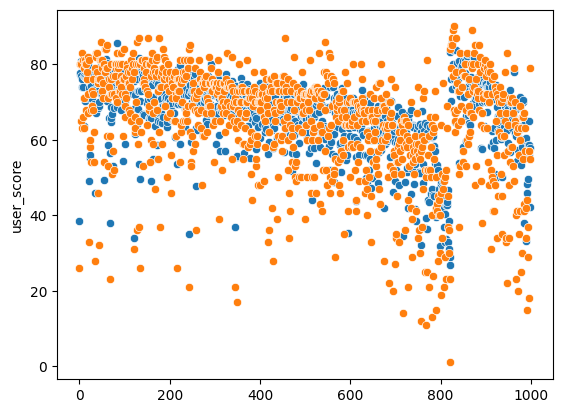

In [21]:
grid_rfr(train, test, "user_score")

In [22]:
def grid_gbr(train,test, target):
    train = train.select_dtypes(exclude=['object'])
    test = test.select_dtypes(exclude=['object'])
    obj = train[target]
    obj_test = test[target]
    test = test.drop([target],axis=1)
    train = train.drop([target],axis=1)


    X = train
    y = obj

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1)
    
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor())
    ])

    parameters = {
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
            "regressor__n_estimators":[50,100,150],
            "regressor__max_depth": [2,3,4,5],
            "regressor__max_features": [2,3,4],
            "regressor__learning_rate":[0.01,0.1,0.5]
            }

    gbr_gs = GridSearchCV(estimator=pipe, param_grid=parameters, cv=3, scoring="accuracy", verbose=3, n_jobs=-1)
    gbr_gs.fit(X_train, y_train)
    final = gbr_gs.best_estimator_
    final.fit(X_train, y_train)
    pred = final.predict(test)


    print("Media Target: ", y.mean())
    print("R2", round(r2_score(obj_test, pred),3))
    print("MAE", round(mean_absolute_error(obj_test, pred),3))
    print("MAPE", round(mean_absolute_percentage_error(obj_test, pred),3))
    print("MSE", round(mean_squared_error(obj_test, pred),3))
    print("RMSE", round(np.sqrt(mean_squared_error(obj_test, pred)),3))

    filename = 'modelo_regression_GBR.pkl'

    with open(filename, 'wb') as archivo_salida:
        pickle.dump(final, archivo_salida)

In [23]:
grid_gbr(train, test, "user_score")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan n

Media Target:  67.79208342200468
R2 0.047
MAE 10.441
MAPE 0.303
MSE 210.123
RMSE 14.496


In [24]:
def grid_knn(train,test, target):
    train = train.select_dtypes(exclude=['object'])
    test = test.select_dtypes(exclude=['object'])
    obj = train[target]
    obj_test = test[target]
    test = test.drop([target],axis=1)
    train = train.drop([target],axis=1)


    X = train
    y = obj

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1)
    
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ("selectkbest", SelectKBest()),
    ('regressor', KNeighborsRegressor())
    ])

    parameters = {
        'scaler__with_mean': [True, False],
        'scaler__with_std': [True, False],
        'selectkbest__k':np.arange(5,15),
        'regressor__n_neighbors': np.arange(5,15)
        }

    knr_gs = GridSearchCV(estimator=pipe, param_grid=parameters, cv=3, scoring="accuracy", verbose=3, n_jobs=-1)
    knr_gs.fit(X_train, y_train)
    final = knr_gs.best_estimator_
    final.fit(X_train, y_train)
    pred = final.predict(test)


    print("Media Target: ", y.mean())
    print("R2", round(r2_score(obj_test, pred),3))
    print("MAE", round(mean_absolute_error(obj_test, pred),3))
    print("MAPE", round(mean_absolute_percentage_error(obj_test, pred),3))
    print("MSE", round(mean_squared_error(obj_test, pred),3))
    print("RMSE", round(np.sqrt(mean_squared_error(obj_test, pred)),3))

    filename = 'modelo_regression_KNR.pkl'

    with open(filename, 'wb') as archivo_salida:
        pickle.dump(final, archivo_salida)

In [25]:
grid_knn(train, test, "user_score")

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


KeyboardInterrupt: 

In [ ]:
def grid_SVR(train,test, target):
    train = train.select_dtypes(exclude=['object'])
    test = test.select_dtypes(exclude=['object'])
    obj = train[target]
    obj_test = test[target]
    test = test.drop([target],axis=1)
    train = train.drop([target],axis=1)


    X = train
    y = obj

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1)
    
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ("selectkbest", SelectKBest()),
    ('regressor', SVR())
    ])

    parameters = {
        'scaler__with_mean': [True, False],
        'scaler__with_std': [True, False],
        'selectkbest__k':np.arange(5,15),
        'regressor__C': [0.1,1,10]
        }
    
    svr_gs = GridSearchCV(estimator=pipe, param_grid=parameters, cv=3, scoring="accuracy", verbose=3, n_jobs=-1)
    svr_gs.fit(X_train, y_train)
    final = svr_gs.best_estimator_
    final.fit(X_train, y_train)
    pred = final.predict(test)


    print("Media Target: ", y.mean())
    print("R2", round(r2_score(obj_test, pred),3))
    print("MAE", round(mean_absolute_error(obj_test, pred),3))
    print("MAPE", round(mean_absolute_percentage_error(obj_test, pred),3))
    print("MSE", round(mean_squared_error(obj_test, pred),3))
    print("RMSE", round(np.sqrt(mean_squared_error(obj_test, pred)),3))

    filename = 'modelo_regression_SVR.pkl'

    with open(filename, 'wb') as archivo_salida:
        pickle.dump(final, archivo_salida)

In [ ]:
grid_SVR(train, test, "user_score")

Fitting 3 folds for each of 120 candidates, totalling 360 fits


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
36 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Usuar

Media Target:  67.79208342200468
R2 0.082
MAE 9.746
MAPE 0.291
MSE 202.433
RMSE 14.228


In [ ]:
def kmeans(train,test, target):
    train = train.select_dtypes(exclude=['object'])
    test = test.select_dtypes(exclude=['object'])
    obj = train[target]
    obj_test = test[target]
    test = test.drop([target],axis=1)
    train = train.drop([target],axis=1)

    kmeans = KMeans()
        
    X = train
    y = obj

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1)

    # Definir el modelo de PCA
    pca = PCA()

    # Definir el modelo de KMeans
    kmeans = KMeans(n_init=10)

    # Definir la tubería con PCA seguido de KMeans
    pipe = Pipeline([
        ('pca', pca),
        ('kmeans', kmeans)
    ])

    # Definir el espacio de búsqueda de hiperparámetros
    param_grid = {
        'pca__n_components': [2, 5, 10],  # Ajusta según la cantidad deseada de componentes principales
        'kmeans__n_clusters': [5, 10, 15, 20]  # Ajusta los valores según sea necesario
    }

    # Configurar Grid Search con validación cruzada
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='adjusted_rand_score')  # Ajusta la métrica según tu problema

    # Entrenar el modelo con el conjunto de entrenamiento
    grid_search.fit(X_train)

    # Obtener el mejor modelo y sus hiperparámetros
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    predictions = best_model.predict(X_test)

    print("Mejores hiperparámetros:", best_params)
    print("Predicciones en el conjunto de prueba:", predictions)
    print("Resultados de la validación cruzada:")
    print(grid_search.cv_results_)

    inercia = best_model.named_steps['kmeans'].inertia_
    print("Inercia del modelo de KMeans:", inercia)



    """with open(filename, 'wb') as archivo_salida:
        pickle.dump(final, archivo_salida)"""

In [ ]:
kmeans(train, test, "user_score")

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 80

Mejores hiperparámetros: {'kmeans__n_clusters': 5, 'pca__n_components': 2}
Predicciones en el conjunto de prueba: [0]
Resultados de la validación cruzada:
{'mean_fit_time': array([0.1042449 , 0.06812015, 0.07361169, 0.06595273, 0.08186507,
       0.08806558, 0.08711863, 0.08841033, 0.10186257, 0.08947382,
       0.1182456 , 0.1272408 ]), 'std_fit_time': array([0.11103174, 0.00834028, 0.0049739 , 0.00392753, 0.00241565,
       0.00525193, 0.00981387, 0.00955228, 0.00753681, 0.00737465,
       0.0084272 , 0.00706841]), 'mean_score_time': array([0.0002131 , 0.00083809, 0.00091715, 0.00103536, 0.00019803,
       0.00084934, 0.00069685, 0.00060573, 0.00064945, 0.00108633,
       0.00118074, 0.0010294 ]), 'std_score_time': array([4.26197052e-04, 4.23071908e-04, 4.96202012e-04, 5.02839649e-05,
       3.96060944e-04, 7.74484743e-04, 5.95648889e-04, 4.94574907e-04,
       5.38503141e-04, 1.39193626e-04, 2.21170449e-04, 5.34502946e-04]), 'param_kmeans__n_clusters': masked_array(data=[5, 5, 5, 10

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
